![Screenshot 2023-06-22 135026.png](<attachment:Screenshot 2023-06-22 135026.png>)
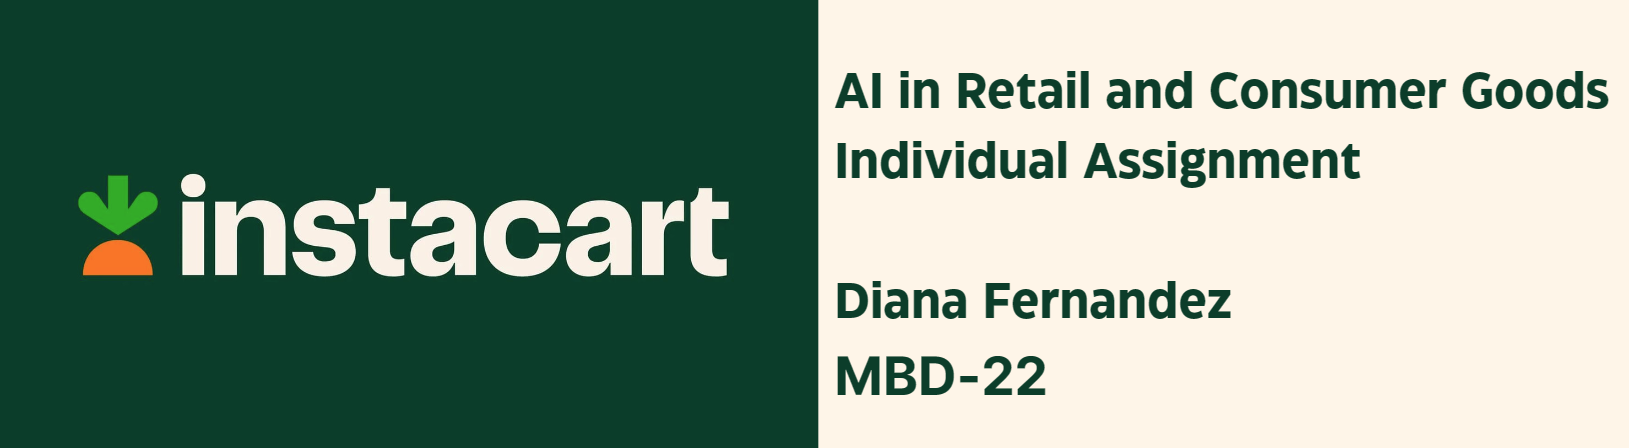

In [1]:
import numpy as np
import pandas as pd
from pandas.core.common import flatten
from annoy import AnnoyIndex
from gensim.models import Word2Vec
from efficient_apriori import apriori
import seaborn as sns

from tqdm import tqdm
import zipfile as zp
from art import *
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF
import plotly.express as px

import plotly.graph_objects as go
import plotly.io as pio

import kaleido as kld


# from PyDictionary import PyDictionary 
import random
import time

#import scikitplot as skplt

#to enable the inline plotting
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

sns.set_style("darkgrid")
sns.color_palette("Greens", 10)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dianaf\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[(0.9176931949250289, 0.9684275278738947, 0.901361014994233),
 (0.8459054209919262, 0.9399307958477509, 0.8228219915417148),
 (0.7558477508650518, 0.9033910034602076, 0.7290426758938869),
 (0.6436447520184544, 0.8561476355247981, 0.6197923875432525),
 (0.5185697808535179, 0.7983391003460207, 0.5150941945405614),
 (0.3827450980392157, 0.7332564398308343, 0.42737408688965783),
 (0.2452133794694348, 0.6602537485582468, 0.35695501730103807),
 (0.1566320645905421, 0.5657670126874279, 0.28608996539792386),
 (0.06082276047673972, 0.47958477508650516, 0.21599384851980008),
 (0.0, 0.38268358323721646, 0.15398692810457515)]

In [2]:
# define Seaborn color palette to use
colors = sns.color_palette("Greens", 10)

In [3]:
# define the fig size of all figures
plt.rcParams["figure.figsize"] = (10,6)
# the directory to unzip the data in
data_directory_path = '/kaggle/working/dataset/'

In [4]:
# Converting the days and hours from numbers to their interpretable form
import datetime
days_of_week = {0: 'Saturday', 
                1: 'Sunday', 
                2: 'Monday',
                3: 'Tuesday',
                4: 'Wednesday',
                5: 'Thursday',
                6: 'Friday'}
hour_nums = list(range(24))
hours_of_day = {hour_num:datetime.time(hour_num).strftime("%I:00 %p") for hour_num in hour_nums}

In [5]:
# Annotate text on graph
def annotate_text(p, append_to_text='%'):
    for p in ax.patches:
        txt = str(p.get_height().round(2)) + append_to_text
        txt_x = p.get_x() + p.get_width()/2.
        txt_y = 0.92*p.get_height()
        ax.text(txt_x,txt_y,txt, fontsize=12, color='Black', ha='center', va='bottom')

## Reading the Instacart dataset

In [6]:
# Reading the csv files into corresponding dataframes
aisles = pd.read_csv("datasets/aisles.csv")
order_products_prior = pd.read_csv("datasets/order_products__prior.csv")
order_products_train = pd.read_csv("datasets/order_products__train.csv")
products = pd.read_csv("datasets/products.csv")
orders = pd.read_csv("datasets/orders.csv")
departments = pd.read_csv("datasets/departments.csv")

# Replacing numbers with their corresponding hour representation
orders['order_hour_of_day'] = orders['order_hour_of_day'].replace(to_replace=hours_of_day)
orders['order_hour_of_day'] = pd.Categorical(orders['order_hour_of_day'], 
                                             ordered=True, 
                                             categories=list(hours_of_day.values()))

# Replacing numbers with their corresponding day of week
# Define the categories of days of week sorted normally from Saturday to Friday
orders['order_dow'] = orders['order_dow'].replace(to_replace=days_of_week)
orders['order_dow'] = pd.Categorical(orders['order_dow'], 
                                     ordered=True, 
                                     categories=list(days_of_week.values()))

## EDA

In [7]:
# Function for EDA. Using the display() function to have  well-formatted tables. We are mainly using pandas to explore the datasets

def dataset_description(df_target):

    print('This is the Dataset shape: %s\n' % (df_target.shape, ))
    print('Dataset columns: %s\n' % df_target.columns)

    print('\nColumns description:\n')
    display(df_target.info())
    display(df_target.describe())  # describe the dataset

    print('\nNull values:\n')
    display(df_target.isnull().sum())  # Identify null values



In [8]:
dataset_description(products)

This is the Dataset shape: (49688, 4)

Dataset columns: Index(['product_id', 'product_name', 'aisle_id', 'department_id'], dtype='object')


Columns description:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


None

,product_id,aisle_id,department_id
count,49688.000000,49688.000000,49688.000000
mean,24844.500000,67.769582,11.728687
std,14343.834425,38.316162,5.850410
min,1.000000,1.000000,1.000000
25%,12422.750000,35.000000,7.000000
50%,24844.500000,69.000000,13.000000
75%,37266.250000,100.000000,17.000000
max,49688.000000,134.000000,21.000000



Null values:



product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

In [9]:
dataset_description(departments)

This is the Dataset shape: (21, 2)

Dataset columns: Index(['department_id', 'department'], dtype='object')


Columns description:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   department_id  21 non-null     int64 
 1   department     21 non-null     object
dtypes: int64(1), object(1)
memory usage: 468.0+ bytes


None

,department_id
count,21.000000
mean,11.000000
std,6.204837
min,1.000000
25%,6.000000
50%,11.000000
75%,16.000000
max,21.000000



Null values:



department_id    0
department       0
dtype: int64

In [10]:
dataset_description(aisles)

This is the Dataset shape: (134, 2)

Dataset columns: Index(['aisle_id', 'aisle'], dtype='object')


Columns description:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    int64 
 1   aisle     134 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


None

,aisle_id
count,134.000000
mean,67.500000
std,38.826537
min,1.000000
25%,34.250000
50%,67.500000
75%,100.750000
max,134.000000



Null values:



aisle_id    0
aisle       0
dtype: int64

In [11]:
dataset_description(order_products_prior)

This is the Dataset shape: (32434489, 4)

Dataset columns: Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered'], dtype='object')


Columns description:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
 3   reordered          int64
dtypes: int64(4)
memory usage: 989.8 MB


None

,order_id,product_id,add_to_cart_order,reordered
count,3.243449e+07,3.243449e+07,3.243449e+07,3.243449e+07
mean,1.710749e+06,2.557634e+04,8.351076e+00,5.896975e-01
std,9.873007e+05,1.409669e+04,7.126671e+00,4.918886e-01
min,2.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,8.559430e+05,1.353000e+04,3.000000e+00,0.000000e+00
50%,1.711048e+06,2.525600e+04,6.000000e+00,1.000000e+00
75%,2.565514e+06,3.793500e+04,1.100000e+01,1.000000e+00
max,3.421083e+06,4.968800e+04,1.450000e+02,1.000000e+00



Null values:



order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [12]:
dataset_description(order_products_train)

This is the Dataset shape: (1384617, 4)

Dataset columns: Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered'], dtype='object')


Columns description:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 4 columns):
 #   Column             Non-Null Count    Dtype
---  ------             --------------    -----
 0   order_id           1384617 non-null  int64
 1   product_id         1384617 non-null  int64
 2   add_to_cart_order  1384617 non-null  int64
 3   reordered          1384617 non-null  int64
dtypes: int64(4)
memory usage: 42.3 MB


None

,order_id,product_id,add_to_cart_order,reordered
count,1.384617e+06,1.384617e+06,1.384617e+06,1.384617e+06
mean,1.706298e+06,2.555624e+04,8.758044e+00,5.985944e-01
std,9.897326e+05,1.412127e+04,7.423936e+00,4.901829e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,8.433700e+05,1.338000e+04,3.000000e+00,0.000000e+00
50%,1.701880e+06,2.529800e+04,7.000000e+00,1.000000e+00
75%,2.568023e+06,3.794000e+04,1.200000e+01,1.000000e+00
max,3.421070e+06,4.968800e+04,8.000000e+01,1.000000e+00



Null values:



order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [13]:
dataset_description(orders)

This is the Dataset shape: (3421083, 7)

Dataset columns: Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order'],
      dtype='object')


Columns description:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   order_id                int64   
 1   user_id                 int64   
 2   eval_set                object  
 3   order_number            int64   
 4   order_dow               category
 5   order_hour_of_day       category
 6   days_since_prior_order  float64 
dtypes: category(2), float64(1), int64(3), object(1)
memory usage: 137.0+ MB


None

,order_id,user_id,order_number,days_since_prior_order
count,3.421083e+06,3.421083e+06,3.421083e+06,3.214874e+06
mean,1.710542e+06,1.029782e+05,1.715486e+01,1.111484e+01
std,9.875817e+05,5.953372e+04,1.773316e+01,9.206737e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,8.552715e+05,5.139400e+04,5.000000e+00,4.000000e+00
50%,1.710542e+06,1.026890e+05,1.100000e+01,7.000000e+00
75%,2.565812e+06,1.543850e+05,2.300000e+01,1.500000e+01
max,3.421083e+06,2.062090e+05,1.000000e+02,3.000000e+01



Null values:



order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [14]:
# Merging the Prior and train order_products
order_products = pd.concat([order_products_train, order_products_prior])
order_products = order_products.merge(products, on='product_id', how='left').merge(orders, on='order_id', how='left').merge(departments, on='department_id').merge(aisles, on='aisle_id')

# Count of total orders
total_orders = order_products['order_id'].nunique()
print('Count of total orders: ', total_orders)
print('Merging products, order_products, and orders tables...')

order_products.head()

Count of total orders:  3346083
Merging products, order_products, and orders tables...


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,department,aisle
0,1,49302,1,1,Bulgarian Yogurt,120,16,112108,train,4,Wednesday,10:00 AM,9.0,dairy eggs,yogurt
1,98,43654,3,1,Whole Milk Greek Blended Vanilla Bean Yogurt,120,16,56463,train,41,Tuesday,08:00 AM,14.0,dairy eggs,yogurt
2,170,8153,6,0,Plain Non-Fat Greek Yogurt,120,16,182389,train,7,Saturday,01:00 PM,14.0,dairy eggs,yogurt
3,631,9203,13,1,Dairy Free Coconut Milk Raspberry Yogurt Alter...,120,16,184099,train,7,Tuesday,09:00 AM,30.0,dairy eggs,yogurt
4,631,15842,14,1,Dairy Free Coconut Milk Yogurt Alternative,120,16,184099,train,7,Tuesday,09:00 AM,30.0,dairy eggs,yogurt


The dataset comprises six distinct files, each containing valuable information:

- Aisles.csv: This file encompasses 134 unique aisle numbers along with their corresponding descriptions.

- Departments.csv: Within this file, you will find 21 unique department numbers accompanied by their descriptions.

- Products.csv: Offering detailed insights, this file contains 49,688 unique product IDs, accompanied by descriptions, aisle IDs, and department IDs.

- Orders.csv: Comprising 3,421,083 unique order IDs, this file provides additional data such as user IDs, order numbers, order day of the week, order hour of the day, days elapsed since the prior order, and evaluation set indicators that identify whether the order belongs to the train, prior, or test set.

- Order_products_prior.csv: This file includes information on order IDs, product IDs, the sequence in which products were added to the cart, and reorder indicators.

- Order_products_train.csv: Similar to the prior file, this file offers data on order IDs, product IDs, the order in which products were added to the cart, and reorder indicators.

Regarding null values in the dataset, it is important to note that there are no occurrences of null values, except for the 'days_since_prior_order' field within the 'Orders' dataset. However, it is essential to acknowledge that these null values hold validity within the dataset.

### Orders Dataset

- The order_id serves as a unique identifier for each order, while order_number is specific to individual users. 

- The first order for any user typically has a "NaN" value for days_since_prior_order, indicating it is their initial purchase. 

- Instacart orders primarily occur during standard working hours, from 9:00 AM to 5:00 PM. 

- Sunday and Monday experience the highest order volume, representing the end and beginning of the week when individuals may need to restock their food supplies.

- Sunday afternoons and Monday mornings witness the peak order times. A weekly pattern emerges, with a significant number of orders placed on days 7, 14, 21, and 28, reflecting a recurring buying behavior. 

- Notably, day 30 displays an upsurge, likely due to the data limitations, grouping all prior orders beyond 30 days. 

- Most orders are concentrated on days 0 and 1, and they primarily occur during the day, with a peak on Saturday afternoons at 1:00 PM and Sunday mornings at 10:00 AM. 

- Between 6:00 AM and 8:00 AM, more than 65% of purchases consist of previously ordered products. 

- Users tend to place their next orders after approximately one week or one month from their last purchase, and the probability of reordering within the same month significantly diminishes after a week has passed. 


**Association between days since last order and the ratio of reorders**
- 74 % of products bought at the same day of prev order, are reorders
- 69% of products bought after 1 week of prev order, are reorders



In [15]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Bar(
    x=orders['order_hour_of_day'].value_counts().sort_index().index,
    y=orders['order_hour_of_day'].value_counts().sort_index(),
    marker=dict(color='#60ab59')
))

fig.update_layout(
    title='Number of Orders Taken by Hour of the Day',
    xaxis_title='Hour',
    yaxis_title='Count',
    xaxis=dict(tickangle=90),
    showlegend=False
)

#fig.show()
# Save the figure as a static image
fig.write_html("Number of Orders Taken by Hour of the Day.html", include_plotlyjs='cdn', full_html=False)


In [16]:
# Which days do people most often order their food?
import plotly.express as px

# Reorder the days of the week
orders['order_dow'] = pd.Categorical(orders['order_dow'], categories=['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], ordered=True)

# Count the occurrences of each day of the week
count_data = orders['order_dow'].value_counts().reset_index()
count_data.columns = ['Day', 'Count']

# Create the bar plot using Plotly
fig = px.bar(count_data, x='Day', y='Count', color_discrete_sequence=['#60ab59'])
fig.update_layout(
    title='Number of Orders Taken by Day of the Week',
    xaxis_title='Day',
    yaxis_title='Count'
)
#fig.show()
# Save the figure as a static image
fig.write_html("Number of Orders Taken by Day of the Week.html", include_plotlyjs='cdn', full_html=False)

In [17]:
agg_dow_hour = orders.groupby(['order_hour_of_day', 'order_dow'])['order_number'].aggregate('count').reset_index()
agg_dow_hour = agg_dow_hour.pivot(index='order_hour_of_day',columns='order_dow', values='order_number')

fig = go.Figure(data=go.Heatmap(
    z=agg_dow_hour.values,
    x=agg_dow_hour.columns,
    y=agg_dow_hour.index,
    colorscale='Greens'))

fig.update_layout(
    title='Heatmap of Orders for Hour of the Day Vs. Day of the Week',
    xaxis_title='Hour of the Day',
    yaxis_title='Day of the Week'
)

#fig.show()
# Save the figure as a static image
fig.write_html("Heatmap of Orders for Hour of the Day Vs. Day of the Week.html", include_plotlyjs='cdn', full_html=False)

In [18]:
# plot the count of days_since_prior_order
fig = px.histogram(orders, x='days_since_prior_order', color_discrete_sequence=['#60ab59'])

fig.update_layout(
    title="Frequency of Days since Prior Order",
    xaxis_title="Days since Prior Order",
    yaxis_title="Count",
    xaxis={'type': 'linear', 'categoryorder': 'array', 'categoryarray': list(range(1, 31))},
    yaxis=dict(title='Count', titlefont=dict(size=12)),
    xaxis_tickangle=-45
)

fig.update_traces(marker=dict(line=dict(color='#FFFFFF', width=0.5)))

#fig.show()
# Save the figure as a static image
fig.write_html("Frequency of Days since Prior Order.html", include_plotlyjs='cdn', full_html=False)

In [19]:
#Number of orders per customer
# Calculate the number of orders per user
order_counts = orders['user_id'].value_counts()

# Create the histogram using Plotly
fig = go.Figure(data=[go.Histogram(x=order_counts, marker=dict(color='#60ab59'), nbinsx=50)])

fig.update_layout(
    title="Distribution of Number of Orders per User",
    xaxis_title="Number of Orders",
    yaxis_title="Frequency",
)

#fig.show()
# Save the figure as a static image
fig.write_html("Distribution of Number of Orders per User.html", include_plotlyjs='cdn', full_html=False)

In [20]:
# Merging the Prior and train order_products
order_products = pd.concat([order_products_train, order_products_prior])
order_products = order_products.merge(products, on='product_id', how='left').merge(orders, on='order_id', how='left').merge(departments, on='department_id').merge(aisles, on='aisle_id')

# Count of total orders
total_orders = order_products['order_id'].nunique()
print('Count of total orders: ', total_orders)
print('Merging products, order_products, and orders tables...')
order_products.head()

Count of total orders:  3346083
Merging products, order_products, and orders tables...


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,department,aisle
0,1,49302,1,1,Bulgarian Yogurt,120,16,112108,train,4,Wednesday,10:00 AM,9.0,dairy eggs,yogurt
1,98,43654,3,1,Whole Milk Greek Blended Vanilla Bean Yogurt,120,16,56463,train,41,Tuesday,08:00 AM,14.0,dairy eggs,yogurt
2,170,8153,6,0,Plain Non-Fat Greek Yogurt,120,16,182389,train,7,Saturday,01:00 PM,14.0,dairy eggs,yogurt
3,631,9203,13,1,Dairy Free Coconut Milk Raspberry Yogurt Alter...,120,16,184099,train,7,Tuesday,09:00 AM,30.0,dairy eggs,yogurt
4,631,15842,14,1,Dairy Free Coconut Milk Yogurt Alternative,120,16,184099,train,7,Tuesday,09:00 AM,30.0,dairy eggs,yogurt


In [21]:
groupeddf = order_products.groupby(['order_id']).agg({'reordered':'mean', 'order_number':'first'}).reset_index().rename(columns={'reordered':'reordered_ratio'})
groupeddf['no_reordered'] = groupeddf['reordered_ratio'] == 0
groupeddf['all_reordered'] = groupeddf['reordered_ratio'] == 1.0

# Count of non-first orders
non_first_orders_Mask = orders.order_number != 1
non_first_orders_count = np.sum(non_first_orders_Mask)

# Ratio of non-first orders containing no previously ordered products vs containing at least one previously ordered products

# Filter out order_number == 1
groupeddf = groupeddf[groupeddf.order_number != 1]

# Calculate the percentage of orders without reordered products
groupeddf['no_reordered'] = groupeddf['reordered_ratio'] == 0
no_reordered_count = groupeddf['no_reordered'].value_counts() / non_first_orders_count * 100

# Create the grouped bar plot using Plotly
fig = go.Figure(data=[
    go.Bar(
        x=['at least one reordered', 'no-reordered products'],
        y=no_reordered_count.values,
        marker=dict(color='#60ab59'),
        text=[f'{val:.2f}%' for val in no_reordered_count.values],
        textposition='auto'
    )
])

fig.update_layout(
    title='Percentage of Orders Having No Reordered Products',
    xaxis_title='',
    yaxis_title='Percentage %'
)

#fig.show()
# Save the figure as a static image
fig.write_html("Percentage of Orders Having No Reordered Products.html", include_plotlyjs='cdn', full_html=False)

# Ratio of non-first orders where their products were all previously purchased

# Calculate the percentage of orders with all products reordered
groupeddf['all_reordered'] = groupeddf['reordered_ratio'] == 1.0
all_reordered_count = groupeddf['all_reordered'].value_counts() / non_first_orders_count * 100

# Create the bar plot using Plotly
fig = go.Figure(data=[
    go.Bar(
        x=['not purely all products are reordered', 'all products are reordered'],
        y=all_reordered_count.values,
        marker=dict(color='#60ab59'),
        text=[f'{val:.2f}%' for val in all_reordered_count.values],
        textposition='auto'
    )
])

fig.update_layout(
    title='Percentage of Orders Having All Products Reordered',
    xaxis_title='',
    yaxis_title='Percentage %'
)

#fig.show()
# Save the figure as a static image
fig.write_html("Percentage of Orders Having All Products Reordered.html", include_plotlyjs='cdn', full_html=False)

In [22]:
# Ploting a histogram for the # of products in an order
count_of_products = order_products.groupby(['order_id'], as_index=False)['product_id'].count()
count_of_products['count_of_products'] = count_of_products['product_id']

# Create the countplot using Plotly
fig = px.histogram(count_of_products, x='count_of_products', color_discrete_sequence=['#60ab59'])

fig.update_layout(
    title='Distribution of Count of Products in Orders',
    xaxis_title='Count of Products per Order',
    yaxis_title='Number of Occurrence',
    xaxis=dict(tickmode='linear', nticks=20),
)

#fig.show()
# Save the figure as a static image
fig.write_html("Distribution of Count of Products in Orders.html", include_plotlyjs='cdn', full_html=False)


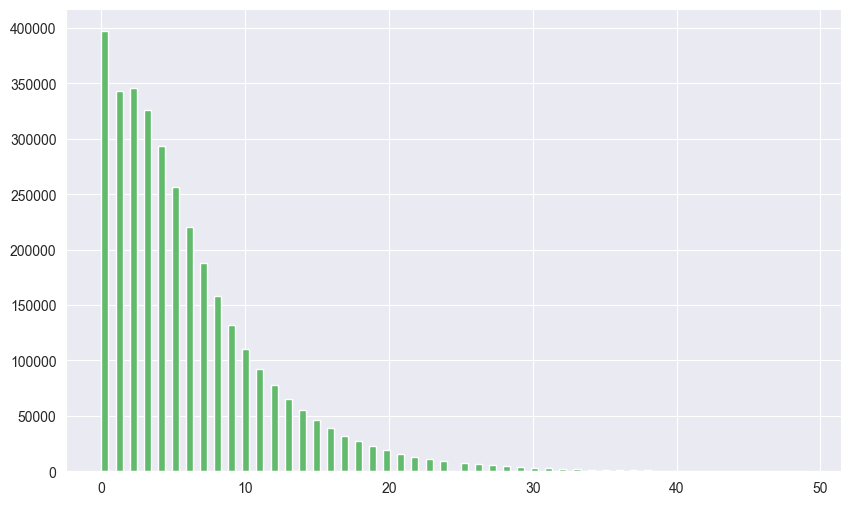

In [23]:
# Ploting a histogram for the # of reordered products in an order
count_of_reordered_products = order_products.groupby(['order_id'], as_index=False)['reordered'].sum()
count_of_reordered_products['count_of_reordered_products'] = count_of_reordered_products['reordered']
less_than_50_reordered_products = count_of_reordered_products[count_of_reordered_products['count_of_reordered_products']<50]
less_than_50_reordered_products['count_of_reordered_products'].hist(bins=100, color=colors[5])

fig = go.Figure(data=[
    go.Histogram(x=less_than_50_reordered_products['count_of_reordered_products'], nbinsx=100, marker=dict(color='#60ab59'))
])

fig.update_layout(
    title='Count of Orders Containing x Count of Reorders',
    xaxis_title='Count of Re-ordered Products per Order',
    yaxis_title='Count of Orders Containing x Count of Reorders'
)

#fig.show()
# Save the figure as a static image
fig.write_html("Count of Orders Containing x Count of Reorders.html", include_plotlyjs='cdn', full_html=False)

# Percentage of orders having x count_of_reordered_products
reordered_products_count_histogram = count_of_reordered_products.groupby(['count_of_reordered_products'], as_index=False).count()
reordered_products_count_histogram['count_of_orders'] = reordered_products_count_histogram['reordered']
reordered_products_count_histogram['percentage_of_this_reordered_count'] = (reordered_products_count_histogram['count_of_orders']/total_orders) * 100
reordered_products_count_histogram = reordered_products_count_histogram[['count_of_reordered_products','count_of_orders','percentage_of_this_reordered_count']]

# Filter reorders counts occuring by prob less than 0.5% 
mask = reordered_products_count_histogram['percentage_of_this_reordered_count'] > 0.5
reordered_products_count_histogram = reordered_products_count_histogram[mask].sort_values(by=['percentage_of_this_reordered_count'], ascending=False)

fig = go.Figure(data=[
    go.Bar(
        x=reordered_products_count_histogram['count_of_reordered_products'],
        y=reordered_products_count_histogram['percentage_of_this_reordered_count'].values,
        marker=dict(color='#60ab59'),
    )
])

fig.update_layout(
    title='Percentage of Orders Containing x Count of Reorders',
    xaxis_title='Count of Re-ordered Products per Basket',
    yaxis_title='Percentage of Orders Containing x Count of Reorders'
)

#fig.show()
# Save the figure as a static image
fig.write_html("Percentage of Orders Containing x Count of Reorders.html", include_plotlyjs='cdn', full_html=False)



In [24]:
# Getting list of user ids, who always reorder products from their first order.
non_first_orders_mask = order_products['order_number'] != 1
groupeddf = order_products[non_first_orders_mask].groupby(['user_id']).agg({'reordered':'mean', 'order_number':'count'}).rename(columns={'reordered':'reordered_ratio'})
mask = groupeddf['reordered_ratio'] == 1
always_reorder_users_id = groupeddf[mask].index.to_list()
print('Count of users who always order the same products every time:', len(always_reorder_users_id))

# getting the orders of the a random user
rand_indx = random.randint(0,len(always_reorder_users_id))
rand_user_id = always_reorder_users_id[rand_indx]
user_mask = orders['user_id'] == rand_user_id
user_orders = orders[user_mask]['order_id'].to_list()
print(f'Orders of user {rand_user_id}:')
print(f'Count of his orders: {len(user_orders)}')
for order_id in user_orders:
    print(f'Order number{order_id}:')
    print(order_products[order_products['order_id'] == order_id]['product_name'].to_list())
    print('--------------')
del groupeddf, mask, always_reorder_users_id

Count of users who always order the same products every time: 685
Orders of user 167792:
Count of his orders: 4
Order number797813:
['Smartwater', 'Drinking Water', 'Organic Variety Pack', 'Mixed Fruit Fruit Snacks']
--------------
Order number3063459:
['Smartwater', 'Drinking Water', 'Organic Variety Pack', 'Mixed Fruit Fruit Snacks']
--------------
Order number3353870:
['Smartwater', 'Drinking Water', 'Mixed Fruit Fruit Snacks']
--------------
Order number2920608:
['Drinking Water', 'Mixed Fruit Fruit Snacks']
--------------


In [25]:
groupeddf = order_products.groupby(['days_since_prior_order']).agg({'reordered': 'mean'}).rename(columns={'reordered':'reordered_ratio'}).reset_index()

fig = go.Figure(data=[
    go.Bar(
        x=groupeddf['days_since_prior_order'],
        y=groupeddf['reordered_ratio']*100,
        marker=dict(color='#60ab59'),
    )
])

fig.update_layout(
    title='Effect of Duration Since Last Order on Reordered Ratio of the New Order',
    xaxis_title='Days Since Last Order',
    yaxis_title='Ratio of Reordered Products in New Order (%)',
    xaxis=dict(tickangle=90),
)

#fig.show()
# Save the figure as a static image
fig.write_html("Effect of Duration Since Last Order on Reordered Ratio of the New Order.html", include_plotlyjs='cdn', full_html=False)

### Products Dataset

**How often a product is purchased?**

These are the top five products that are commonly ordered:

- Banana
- Bag of Organic Bananas
- Organic Strawberries
- Organic Baby Spinach
- Organic Hass Avocado

Approximately 14% of all orders include bananas.

There is a high frequency of orders for organic products.

In [26]:
# Sorting products descendingly by their frequency of being ordered
products_frequency_desc = order_products.groupby('product_name')['order_id'].count().reset_index()
products_frequency_desc.rename(columns={'order_id': 'count_of_ordering'}, inplace=True)
products_frequency_desc = products_frequency_desc.sort_values(by='count_of_ordering', ascending=False)

# Calculate the percentage of being ordered for the 30 most frequently ordered products
products_frequency_desc['percentage_of_ordering'] = (products_frequency_desc['count_of_ordering'] / total_orders) * 100

# Create the bar plot using Plotly
fig = go.Figure(data=[
    go.Bar(
        x=products_frequency_desc['product_name'].iloc[:30],
        y=products_frequency_desc['percentage_of_ordering'].iloc[:30],
        marker=dict(color='#EB8921')
    )
])

fig.update_layout(
    title='Percentage of Ordering a Product',
    xaxis_title='30 Most Frequently Ordered Products',
    yaxis_title='Percentage of Being Ordered',
    xaxis=dict(tickangle=90),
)

#fig.show()
# Save the figure as a static image
fig.write_html("Percentage of Ordering a Product.html", include_plotlyjs='cdn', full_html=False)


# Create the bar plot using Plotly
fig = go.Figure(data=[
    go.Bar(
        x=products_frequency_desc['product_name'].iloc[:30],
        y=products_frequency_desc['count_of_ordering'].iloc[:30],
        marker=dict(color='#EB8921')
    )
])

fig.update_layout(
    title='Count of Orders Having a Product',
    xaxis_title='30 Most Frequently Ordered Products',
    yaxis_title='Count of Orders',
    xaxis=dict(tickangle=90),
)

#fig.show()
# Save the figure as a static image
fig.write_html("Count of Orders Having a Product.html", include_plotlyjs='cdn', full_html=False)

**How often a product is the first item purchased?**

Here are the top five products that are most commonly added as the first item:

- Banana
- Bag of Organic Bananas
- Organic Whole Milk
- Organic Strawberries
- Organic Hass Avocado

Out of all orders, approximately 3.4% of them have Banana as the first product added to the cart.

It is observed that products containing milk have a significantly higher probability of being reordered.

Similarly, organic products exhibit a substantial likelihood of being reordered.

In [27]:
# Sorting products by the count of times they appeared first in cart
first_order_product = order_products[order_products['add_to_cart_order'] == 1]
first_product_freq_desc = first_order_product.groupby(['product_name'])['order_id'].count().reset_index().sort_values(by='order_id', ascending=False)
first_product_freq_desc.rename(columns={'order_id': 'count_of_ordering_first'}, inplace=True)

# Calculate the percentage of being ordered first for the 30 most first ordered products
first_product_freq_desc['percentage_of_ordering_first'] = (first_product_freq_desc['count_of_ordering_first'] / total_orders) * 100

# Create the bar plot using Plotly
fig = go.Figure(data=[
    go.Bar(
        x=first_product_freq_desc['product_name'].iloc[:30],
        y=first_product_freq_desc['percentage_of_ordering_first'].iloc[:30],
        marker=dict(color='#EB8921')
    )
])

fig.update_layout(
    title='How Often a Product is the First Item Purchased?',
    xaxis_title='30 Most First Ordered Products',
    yaxis_title='Probability of Being Ordered First',
    xaxis=dict(tickangle=90),
)

#fig.show()
# Save the figure as a static image
fig.write_html("How Often a Product is the First Item Purchased.html", include_plotlyjs='cdn', full_html=False)

In [28]:
# Filter non-first orders and calculate the reordered ratio for each product
non_first_orders_mask = order_products['order_number'] != 1
groupeddf = order_products[non_first_orders_mask].groupby('product_name').agg({'order_id': 'count', 'reordered': 'mean'}).reset_index().rename(columns={'reordered': 'reordered_ratio', 'order_id': 'orders_count'})

# Filter products with over 10,000 order count
groupeddf = groupeddf[groupeddf['orders_count'] > 10000]
# Sort by the products with the highest probability to be reordered
groupeddf = groupeddf.sort_values(by=['reordered_ratio'], ascending=False)

# Create the bar plot using Plotly
fig = go.Figure(data=[
    go.Bar(
        x=groupeddf['product_name'].iloc[:30],
        y=groupeddf['reordered_ratio'].iloc[:30],
        marker=dict(color='#EB8921')
    )
])

fig.update_layout(
    title='Probability of Reordering a Product',
    xaxis_title='30 Most Reordered Products',
    yaxis_title='Probability of Being Reordered',
    xaxis=dict(tickangle=90),
    yaxis=dict(tickformat=".1%"),
)

#fig.show()
# Save the figure as a static image
fig.write_html("Probability of Reordering a Product.html", include_plotlyjs='cdn', full_html=False)

### Departments and Aisles Dataset

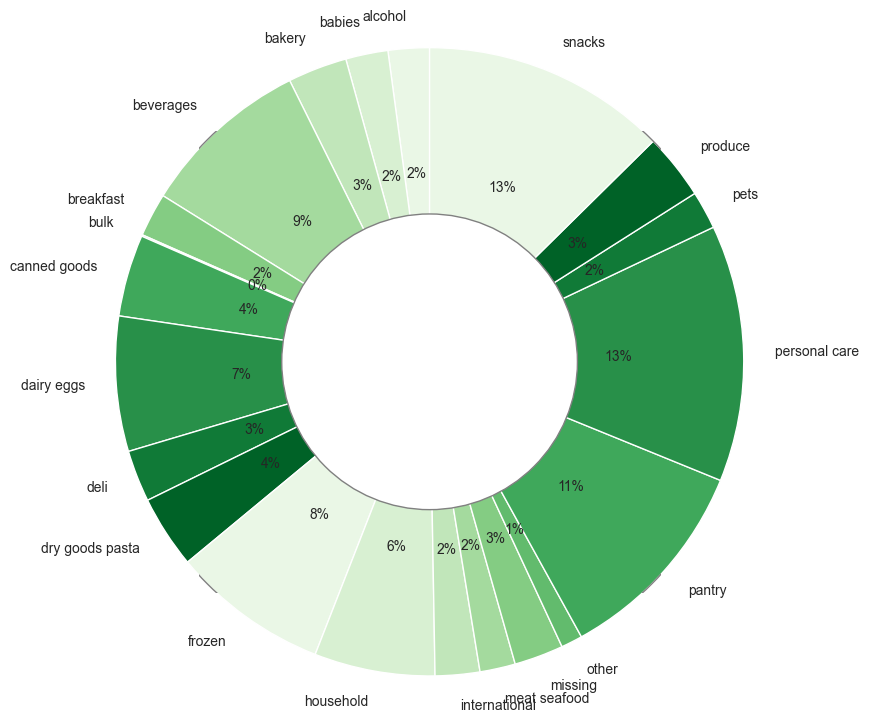

In [29]:
# count of products in each department

# merge products with departments
prod_dept = products.merge(departments, on='department_id', how='left')
data = prod_dept.groupby(['department']).agg({'product_id':'count'}).reset_index().rename(columns={'product_id':'products_count'})
plt.pie(data['products_count'], labels = data['department'], colors = colors, autopct='%.0f%%', radius=1.7, startangle=90, 
        wedgeprops={"linewidth": 1, "edgecolor": "white"}, labeldistance=1.1)

# Add inner circle and outer border to the donut chart
# Allows us to have white seperations between the segments
centre_circle = plt.Circle((0, 0), 0.8, fc='white', ec='grey')
outer_circle = plt.Circle((0, 0), 1.7, fc='None', ec='grey')
fig = plt.gcf()

# Adding the circles to the chart
fig.gca().add_artist(centre_circle)
fig.gca().add_artist(outer_circle)

plt.show()

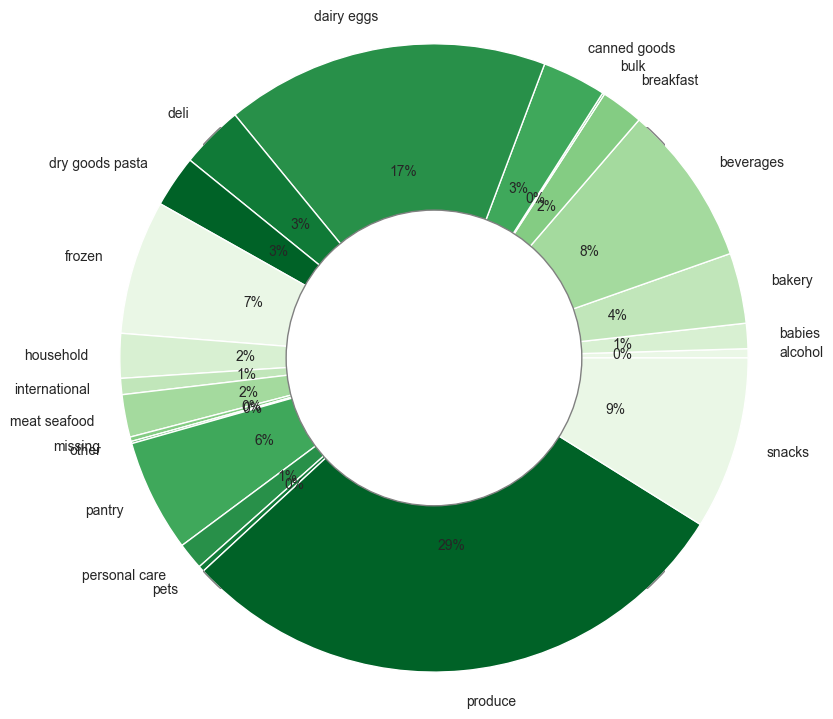

In [30]:
# From All ordered products, the count of contribution of each department
# Group by the count of ordering from a department
total_ordered_products = order_products.shape[0]
groupeddf = order_products.groupby(['department'], as_index=False).count().rename(columns={'department_id':'count_of_ordered_prods'})

plt.pie(groupeddf['count_of_ordered_prods'], labels = groupeddf['department'], colors = colors, autopct='%.0f%%', radius=1.7)
# Add inner circle and outer border to the donut chart
# Allows us to have white seperations between the segments
centre_circle = plt.Circle((0, 0), 0.8, fc='white', ec='grey')
outer_circle = plt.Circle((0, 0), 1.7, fc='None', ec='grey')
fig = plt.gcf()

# Adding the circles to the chart
fig.gca().add_artist(centre_circle)
fig.gca().add_artist(outer_circle)
plt.show()

In [31]:
# From All ordered products, the count of contribution of each aisle
# Group by the count of ordering from an aisle
total_ordered_products = order_products.shape[0]
groupeddf = order_products.groupby(['aisle'], as_index=False).agg({'aisle_id':'count'}).rename(columns={'aisle_id':'count_of_ordered_prods'})
groupeddf['percentage_of_ordered_prods'] = groupeddf['count_of_ordered_prods']/total_ordered_products*100
groupeddf = groupeddf.sort_values(by=['count_of_ordered_prods'], ascending=False)

# Create the bar chart using Plotly
fig = go.Figure(data=[go.Bar(
    x=groupeddf['aisle'].iloc[:30],
    y=groupeddf['percentage_of_ordered_prods'].iloc[:30],
    marker=dict(color='#EB8921'),
)])

fig.update_layout(
    title='30 Most Frequently Bought Aisles',
    xaxis_title='Aisle Name',
    yaxis_title='Percentage of Ordering Products from an Aisle',
    xaxis=dict(tickangle=90),
)

#fig.show()
# Save the figure as a static image
fig.write_html("30 Most Frequently Bought Aisles.html", include_plotlyjs='cdn', full_html=False)

In [32]:
# Heatmap on the probability of non-new users to reorder for each day each hour
non_first_orders = order_products['order_number'] != 1
groupeddf = order_products[non_first_orders].groupby(['department']).agg({'reordered':'mean'}).reset_index().rename(columns={'reordered':'reordered_ratio'})

groupeddf = groupeddf.sort_values(by=['reordered_ratio'], ascending=False)

# Create the bar chart using Plotly
fig = go.Figure(data=[go.Bar(
    x=groupeddf['department'],
    y=groupeddf['reordered_ratio'],
    marker=dict(color='#EB8921'),
)])

fig.update_layout(
    title='Ratio of Reordering from Departments',
    xaxis_title='Department Name',
    yaxis_title='Ratio of Reordering',
    xaxis=dict(tickangle=90),
)

#fig.show()
# Save the figure as a static image
fig.write_html("Ratio of Reordering from Departments.html", include_plotlyjs='cdn', full_html=False)


In [33]:
# Take aisle name as input 
# aisle_name = input('Enter the aisle name you want to generate heatmap for:')

aisle_name = 'bread'
exists = aisle_name in aisles['aisle'].unique()

if exists:
    aisle_order_products = order_products[order_products['aisle'] == aisle_name]
    groupeddf = aisle_order_products.groupby(['order_dow', 'order_hour_of_day']).agg('count').reset_index().rename(columns={'order_id':'order_prods_count'})
    heatmap_data = groupeddf.pivot(columns='order_dow', index='order_hour_of_day', values='order_prods_count')

    fig = go.Figure(data=go.Heatmap(
        z=heatmap_data.values,
        x=heatmap_data.columns,
        y=heatmap_data.index,
        colorscale="Greens"
    ))

    fig.update_layout(
        title='Frequency of products ordered for ' + aisle_name + ' in per each day and hour',
        xaxis_title='Day of week',
        yaxis_title='Hour of day'
    )

   #fig.show()
# Save the figure as a static image
fig.write_html("Frequency of products ordered for in per each day and hour.html", include_plotlyjs='cdn', full_html=False)
